# DataLab 2021 Cup2: Object Detection

#### 無敵的吧
#### 110065536 陳俊元 
#### 110062645 王昱文
#### 107021115 錢珈鋒
#### 106000115 林超偉

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, Model
import sys
import evaluate
import cv2
import matplotlib.pyplot as plt
from ensemble_boxes import *
from tensorflow.python.keras import regularizers
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

os.environ["CUDA_DEVICE_OR_DER"] = "PCI_BUS_ID"  #see
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/home/wangyuwen/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [3]:
'''training_data_path = '../dataset/DL_kaggle2/pascal_voc_training_data.txt'
training_data_path = os.path.abspath(training_data_path)'''

"training_data_path = '../dataset/DL_kaggle2/pascal_voc_training_data.txt'\ntraining_data_path = os.path.abspath(training_data_path)"

In [4]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [5]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
TRAIN_PATH = './data/pascal_voc_split_train_aug.txt'
TRAIN_IMAGE_DIR = './data/train/'
VALID_PATH = './data/pascal_voc_split_val_aug.txt'
VALID_IMAGE_DIR = './data/valid/'
'''DATA_PATH = training_data_path
IMAGE_DIR = '../dataset/DL_kaggle2/VOCdevkit_train/VOC2007/JPEGImages/'
IMAGE_DIR = os.path.abspath(IMAGE_DIR)'''

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 20

# Dataloader

In [6]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self, file_path, img_dir):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        self.file_path = file_path
        self.img_dir = img_dir
        # filling the record_list
        input_file = open(self.file_path, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(self.img_dir+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1
#         image = preprocess_input(image)
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

# Pretrain from InceptionResNetV2

In [7]:
class conv_leaky_relu(Model):
	def __init__(self, filters, size, stride):
		super(conv_leaky_relu, self).__init__()

		self.conv = layers.Conv2D(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),  use_bias=False)
		self.bn = keras.layers.BatchNormalization()
		self.LeakyReLU = layers.LeakyReLU(0.1)

	def call(self, inputs):
		x = self.bn(self.conv(inputs))
		x = self.LeakyReLU(x)
		return x

In [8]:
class ResNet_YOLO(Model):
    def __init__(self):
        super(ResNet_YOLO, self).__init__()
        self.backbone = ResNet152V2(include_top = False, weights = 'imagenet')
        for layer in self.backbone.layers:
            layer.trainable = False
        
        self.conv1 = conv_leaky_relu(1024, 3, 1)
        self.conv2 = conv_leaky_relu(1024, 3, 2)
        self.conv3 = conv_leaky_relu(1024, 3, 1)
        self.conv4 = conv_leaky_relu(1024, 3, 1)
        
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(
            4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
            kernel_regularizer=regularizers.l2(l2=5e-4), use_bias=False
        ) 
        self.bn = layers.BatchNormalization()
        self.relu = layers.LeakyReLU(0.1)
        self.classification = layers.Dense(
            1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01),
            kernel_regularizer=regularizers.l2(l2=5e-4)
        )
    
    def call(self, inputs):
        x = self.backbone(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.bn(self.dense(x))
        x = self.relu(x)
        x = self.classification(x)
        
        return x

In [9]:
model_final = ResNet_YOLO()
model_final.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model_final.summary()

Model: "res_net_yolo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, None, None, 2048)  58331648  
_________________________________________________________________
conv_leaky_relu (conv_leaky_ multiple                  18878464  
_________________________________________________________________
conv_leaky_relu_1 (conv_leak multiple                  9441280   
_________________________________________________________________
conv_leaky_relu_2 (conv_leak multiple                  9441280   
_________________________________________________________________
conv_leaky_relu_3 (conv_leak multiple                  9441280   
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                 

# YOLO Loss

In [10]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [11]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    total_loss = 0.
    class_loss = 0.
    object_loss = 0.
    noobject_loss = 0.
    coord_loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results  = losses_calculation(predict, label[j:j+1, :])
            total_loss = total_loss + results

    return total_loss/BATCH_SIZE

In [12]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE
    
    total_loss = class_loss + object_loss + noobject_loss + coord_loss

    return total_loss

# InceptionResNetV2 training

In [13]:
dataset = DatasetGenerator(TRAIN_PATH, TRAIN_IMAGE_DIR).generate()
dataset_valid = DatasetGenerator(VALID_PATH, VALID_IMAGE_DIR).generate()

In [14]:
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, momentum=0.9, clipnorm=0.001)
train_loss_metric = tf.keras.metrics.Mean(name='loss')
valid_loss_metric = tf.keras.metrics.Mean(name='loss1')

In [15]:
if not os.path.exists('./ckpts/InceptionResNetV2'):
    os.makedirs('./ckpts/InceptionResNetV2')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=model_final)

manager = tf.train.CheckpointManager(ckpt, './ckpts/InceptionResNetV2', max_to_keep=3,
                                     checkpoint_name='inceptionresnetv2_yolo')

In [16]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = model_final(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        total_loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(total_loss)

    grads = tape.gradient(total_loss, model_final.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_final.trainable_weights))

In [17]:
@tf.function
def valid_step(image, labels, objects_num):
    outputs = model_final(image)
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = tf.concat([class_probs, confs, boxes], 3)

    loss = yolo_loss(predicts, labels, objects_num)
    valid_loss_metric(loss)

In [18]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    valid_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)
    for idx, (image, labels, objects_num) in enumerate(dataset_valid):
        valid_step(image, labels, objects_num)

    print("{}, Epoch {}: train_loss {}".format(datetime.now(), i+1, train_loss_metric.result()))
    print('valid_loss {}'.format(valid_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2021-11-22 12:00:53.520343, start training.
2021-11-22 12:03:24.356989, Epoch 1: train_loss 17.29876136779785
valid_loss 14.721671104431152
Saved checkpoint for epoch 1: ./ckpts/InceptionResNetV2/inceptionresnetv2_yolo-1
2021-11-22 12:05:40.709950, Epoch 2: train_loss 13.059460639953613
valid_loss 12.210291862487793
Saved checkpoint for epoch 2: ./ckpts/InceptionResNetV2/inceptionresnetv2_yolo-2
2021-11-22 12:07:57.384046, Epoch 3: train_loss 10.78189754486084
valid_loss 11.047388076782227
Saved checkpoint for epoch 3: ./ckpts/InceptionResNetV2/inceptionresnetv2_yolo-3
2021-11-22 12:10:14.441564, Epoch 4: train_loss 9.361408233642578
valid_loss 10.461494445800781
Saved checkpoint for epoch 4: ./ckpts/InceptionResNetV2/inceptionresnetv2_yolo-4
2021-11-22 12:12:28.816526, Epoch 5: train_loss 8.365060806274414
valid_loss 10.140205383300781
Saved checkpoint for epoch 5: ./ckpts/InceptionResNetV2/inceptionresnetv2_yolo-5
2021-11-22 12:14:45.414964, Epoch 6: train_loss 7.562053680419922
vali

# Test

In [19]:
def process_outputs_multi(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the confidence that larger than threshold, at most 20 samples
    threshold = 0.02
    sample = 20
    
    #choose top 20 confidence that larger than threshold
    _P = P.flatten()
    indexes = np.asarray([x for x in np.argsort(_P)[-sample:] if _P[x] >= threshold])
    
    #if no confidence larger than threshold, choose the max one
    if len(indexes) == 0:
        indexes = np.asarray([np.argmax(_P)])
    
    idx_cnts = len(indexes)
    indexes = np.unravel_index(indexes, P.shape)
    max_conf = P[indexes]
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    class_num = []
    
    indexes = np.asarray(indexes)
    
    for cnts in range(idx_cnts):
        index = indexes[:,cnts]

        _class_num = index[3]

        coordinate = np.reshape(coordinate, 
                                (CELL_SIZE, 
                                 CELL_SIZE,
                                 BOXES_PER_CELL, 
                                 4))

        max_coordinate = coordinate[index[0], index[1], index[2],:]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        _xmin = xcenter - w/2.0
        _ymin = ycenter - h/2.0

        _xmax = _xmin + w
        _ymax = _ymin + h
        
        if _xmin < 0:
            _xmin = 1
        if _ymin < 0:
            _xmin = 1
        if _xmax > IMAGE_SIZE:
            _xmin = IMAGE_SIZE - 1
        if _xmax > IMAGE_SIZE:
            _xmin = IMAGE_SIZE - 1
        xmin.append(_xmin)
        ymin.append(_ymin)
        xmax.append(_xmax)
        ymax.append(_ymax)
        class_num.append(_class_num)
        
    boxes_list=[]
    for i in range(len(xmin)):
        box=[xmin[i]/448., ymin[i]/448., xmax[i]/448., ymax[i]/448.]
        boxes_list.append(box)
    scores_list = [max_conf]
    labels_list = [class_num]
    weights = [3]

    iou_thr = 0.05
    skip_box_thr = 0.05
    sigma = 0.1
    boxes, scores, labels = nms([boxes_list], scores_list, labels_list, weights=None, iou_thr=iou_thr)
    Xmin = []
    Ymin = []
    Xmax = []
    Ymax = []
    for i in range(len(labels)):
        Xmin.append(int(boxes[i][0]*448))
        Ymin.append(int(boxes[i][1]*448))
        Xmax.append(int(boxes[i][2]*448))
        Ymax.append(int(boxes[i][3]*448))
    return np.asarray(Xmin), np.asarray(Ymin), np.asarray(Xmax), np.asarray(Ymax), np.asarray(labels), np.asarray(scores)

In [26]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [20]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [21]:
ckpt = tf.train.Checkpoint(net=model_final)
ckpt.restore('./ckpts/InceptionResNetV2/inceptionresnetv2_yolo-20')

In [22]:
@tf.function
def prediction_step(img):
    return model_final(img, training=False)

# write prediction txt file

In [27]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
        #print(img_name[i:i+1].numpy()[0].decode('ascii')+" %f %f %f %f %f %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
        
        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [28]:
sys.path.insert(0, './evaluate')

In [29]:
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation


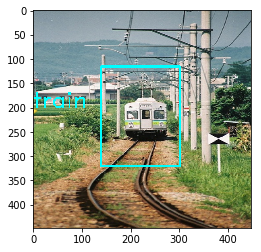

In [32]:
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = model_final(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()


# ReadMe

首先我們使用DataAugmentationForObjectDetection

所以第一步是想使用git clone https://github.com/Paperspace/DataAugmentationForObjectDetection 將這個資料下載下來
接著在data_process中使用data_aug()這個function裡面使用
我們為了方便把code寫得有點醜，我們是直接把他寫死然後一個一個換aug的效果
最後把產生出來的txt和img利用下面的merge整合在一個資料夾裡面

而aug&split_train_val.ipynb檔案是我們當初拿來做測試的，裡面主要只用train_val這個功能
evaluate.py是老師給的檔案

當img和txt都整合在一起之後就可以在kaggle02_report裡面的model進行training


# What kind of models you have tried and how did they work.

在pretrain model的部份我們選用了非常多model
像是EfficientNetB7, InceptionResNetV2, MobileNet, ResNet101V2, ResNet152V2, ResNet50V2, VGG19最後發現resnet152V2的效果最好
而我們也沒有再去對pretrain的部分做finetune而是直接把pretrain固定並且去train YOLO的部分

我們也額外加了幾個block，像是做batchnormalization以及加入LeakyReLU還有Dense
而learning rate的情況我們發現如果值給的太大很容易會出現NaN，而model太大的話training的時間會很久通常一個epoch都train了15分鐘以上
所以選擇learning rate和epoch model的複雜度以及對於時間的trade off讓我們調整了很久，而看起來也還有改進的空間


# Anything you've done and want to tell us.

#### ●Data Augmentation:
我們使用助教們的建議也就是data augmentation，因為我們去找其他解決object detection的問題，通常人家的training data都比我們多很多
因此我們使用了一個github產生出非常多不同種的augmentation像是調整HSV,Rotate,Shear,Flip,並且也對他們進行排列組合，最後並且搭配了raw data
大約產生了5萬多張data，並且發現通常圖片越多張效果都會更好，但最後仍卡在一個分數上不去，我們則推測應該有其他問題

#### ●Validation:
我們一開始在檢測model是否堪用的時候使用20:80的比例去切training 跟 validation data但最後我們發現我們也需要這20%的圖片，因此當我們決定好了
model之後，我們就把validtion移除了，我們就全力將圖片餵入model中進行training

#### ●Multi detection:
這個部份我們花了很久才發現，一直在懷疑到底為甚麼有組別可以這麼高，對於pretrain model大多數的同學應該是懶得去fine tune，我們才恍然大悟發現我們根本忘記檢查output出來的結果，對於部分的圖片output
之後才發現原來按照助教的範例對於所有的圖片僅會畫一個boundary，於是我們便開始思考如果讓detection一次輸出多個boundary
但最後的code似乎有點問題，而且讓我們的accuracy越來越低，不知道哪個部份出了問題。看起來80分的baseline應該就是差在這個部分

#### ●Python files:
為了方便團隊合作以及維護，我們將對於data的preprocess(包含augmentation、validation等)放在.py檔裡面，主要的model架構則是在.ipynb檔案裡面
path的地方是寫死的，因為我們將dataset下載至同一個server以減少上傳下載的時間


# What problems occurred and how did you solve them.

#### ●Define class:
對於define class的部分也可以靈活調整，原本一張圖片可能會有很多class，我們決定把信心較低的直接不讀boundary也就是當成背景

